In [23]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import MinMaxScaler
import os

import scipy as sp

# _FOLDER = "/home/acq18mk/master/results/results/"
_FOLDER = "/home/juanjo/Work_Postdoc/my_codes_postdoc/DrugProfiles-master/results_with_NonAffecting_Drugs/"

### Coding Part

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
# #columns to normalise:
# with open(_FOLDER+"columns_to_normalise.txt", 'r') as f:
#     columns_to_normalise = [line.rstrip('\n') for line in f]
# # *****************************************

with open(_FOLDER+"X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************

In [24]:
GDSC_Info = pd.read_csv(_FOLDER+"Cell_list_GDSC.csv")  #Contains info of cancer types for both GDSC1 and GDSC2

In [25]:
df_GDSC1 = GDSC_Info[GDSC_Info["Dataset"]=="GDSC1"] 

In [26]:
df_OneCancer = df_GDSC1[df_GDSC1["Tissue"]=="lung"].reset_index()

In [27]:
#df_OneCancer = df_GDSC1.reset_index().copy()

In [28]:
all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

datasets = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4"]

X_feat_dict = {"Dataset 1": X_cancer_cell_lines ,
               "Dataset 2": ["MAX_CONC"] + X_targets + X_target_pathway + X_cancer_cell_lines ,
               "Dataset 3": ["MAX_CONC"] + X_PubChem_properties +  X_cancer_cell_lines,
               "Dataset 4": ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway + X_cancer_cell_lines}

### Coefficient_1

train_drug = train_df_50.copy()
test_drug = test_df_50.copy()
  
data_set = "Dataset 4" 
X_columns = X_feat_dict[data_set]

In [29]:
df_train_drug_new = train_drug[train_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][0]]
for i in range(1,df_OneCancer.shape[0]):
    df_aux = train_drug[train_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][i]]
    df_train_drug_new = pd.concat([df_train_drug_new, df_aux])
    
df_test_drug_new = test_drug[test_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][0]]
for i in range(1,df_OneCancer.shape[0]):
    df_aux = test_drug[test_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][i]]
    df_test_drug_new = pd.concat([df_test_drug_new, df_aux])

In [30]:
df_train_drug_new = df_train_drug_new.reset_index()
df_test_drug_new = df_test_drug_new.reset_index()

In [31]:
scaler = MinMaxScaler().fit(df_train_drug_new[X_columns])
Xtrain_drug = scaler.transform(df_train_drug_new[X_columns])
Xtest_drug = scaler.transform(df_test_drug_new[X_columns])

y_train_drug = np.clip(df_train_drug_new["norm_cells_"+str(1)].values[:,None],1.0e-9,1.0)
y_test_drug =  np.clip(df_test_drug_new["norm_cells_"+str(1)].values[:,None],1.0e-9,1.0)
print(y_train_drug.shape)
for i in range(2,10):
    y_train_drug = np.concatenate((y_train_drug,np.clip(df_train_drug_new["norm_cells_"+str(i)].values[:,None],1.0e-9,1.0)),1)
    y_test_drug = np.concatenate((y_test_drug,np.clip(df_test_drug_new["norm_cells_"+str(i)].values[:,None],1.0e-9,1.0)),1)

(9108, 1)


In [32]:
params_4_sig_train = df_train_drug_new["param_"+str(1)].values[:,None]
params_4_sig_test = df_test_drug_new["param_"+str(1)].values[:,None]
for i in range(2,5):
    params_4_sig_train = np.concatenate((params_4_sig_train,df_train_drug_new["param_"+str(i)].values[:,None]),1)
    params_4_sig_test = np.concatenate((params_4_sig_test,df_test_drug_new["param_"+str(i)].values[:,None]),1)

In [33]:
### Training data for the GP ###
output_dim = y_train_drug.shape[1]
N_per_out = Xtrain_drug.shape[0]
Xall = Xtrain_drug.copy()  #
Yall = y_train_drug.copy()

### Testing data for the GP ###
N_per_out_test = Xtest_drug.shape[0]
Xtest = Xtest_drug.copy()  #
Ytest = y_test_drug.copy()

In [34]:
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

In [35]:
Yall.shape

(9108, 9)

0.40036989977246024


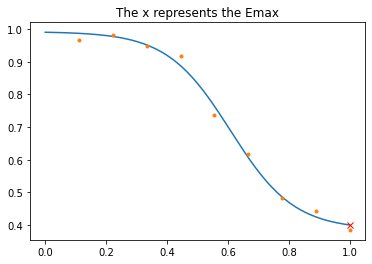

In [36]:
import matplotlib.pyplot as plt
x_lin = np.linspace(0,1,1000)
x_real_dose = np.linspace(0.111111,1,9)
x_lin_tile = np.tile(x_lin,(params_4_sig_train.shape[0],1))
#(x_lin,params_4_sig_train.shape[0],1).shape
Ydose_res = []
Emax = []
for i in range(params_4_sig_train.shape[0]):
    Ydose_res.append(sigmoid_4_param(x_lin_tile[i,:],*params_4_sig_train[i,:]))
    Emax.append(Ydose_res[i][-1])

posy = 900        
plt.plot(x_lin,Ydose_res[posy])
plt.plot(x_real_dose,Yall[posy,:],'.')
plt.plot(x_lin[-1],Emax[posy],'rx') 
plt.title("The x represents the Emax")
print(Emax[posy])

#x_lin_tile.shape


# Compute Log(Emax)

In [37]:
#Here we make the log(Emax) as in the papers they authors usually use the log(IC50) as target.
Emax = np.log(np.array(Emax))

95.4358423235212

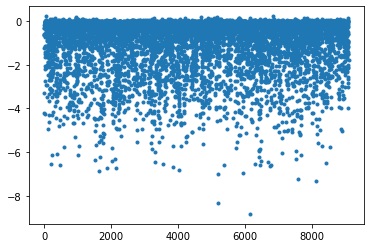

In [38]:
plt.plot(Emax,'.')
Emax.shape[0]**0.5

In [39]:
#df_train_drug_new["COSMIC_ID"]
df_cosmic_train = df_train_drug_new[['COSMIC_ID','DRUG_ID']]
df_group_train = df_cosmic_train.groupby("DRUG_ID")['COSMIC_ID'].unique()
myarray_train = df_group_train.values
for i in range(myarray_train.shape[0]):
    if i==0:
        myset = {value for value in myarray_train[i]}
    else:
        myset = myset.union({value for value in myarray_train[i]})

In [40]:
df_cosmic_test = df_test_drug_new[['COSMIC_ID','DRUG_ID']]
df_group_test = df_cosmic_test.groupby("DRUG_ID")['COSMIC_ID'].unique()
myarray_test = df_group_test.values
for i in range(myarray_test.shape[0]):
    myset = myset.union({value for value in myarray_test[i]})

In [41]:
len(myset)
#myset

194

In [42]:
df_drugID_train = df_train_drug_new[['COSMIC_ID','DRUG_ID']]
df_groupDrugID_train = df_drugID_train.groupby("COSMIC_ID")['DRUG_ID'].unique()
myarray_Drug_train = df_groupDrugID_train.values
for i in range(myarray_Drug_train.shape[0]):
    if i==0:
        myset_Drug = {value for value in myarray_Drug_train[i]}
    else:
        #print(len({value for value in myarray_Drug[i]}))
        aux_set = {value for value in myarray_Drug_train[i]}
        myset_Drug = myset_Drug.union(aux_set.copy())

In [43]:
df_drugID_test = df_test_drug_new[['COSMIC_ID','DRUG_ID']]
df_groupDrugID_test = df_drugID_test.groupby("COSMIC_ID")['DRUG_ID'].unique()
myarray_Drug_test = df_groupDrugID_test.values
for i in range(myarray_Drug_test.shape[0]):
    aux_set = {value for value in myarray_Drug_test[i]}
    myset_Drug = myset_Drug.union(aux_set.copy())

In [44]:
#myarray_Drug[5]
len(myset_Drug)
#myset_Drug
#df_groupDrugID_train.values[1].shape
#194*208
#139*790

208

In [45]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a K-fold for cross-validation"
from sklearn.model_selection import KFold, cross_val_score
Xind = np.arange(N_per_out)
k_fold = KFold(n_splits=5,shuffle=True,random_state=0)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Nfold = 0
select_fold = 0
my_val_Folds = []
for train_id, val_id in k_fold.split(Xind):
    if Nfold == select_fold:
        print(f"Using Fold {Nfold}")
        Xval = Xall[val_id, :].copy()
        Xtrain = Xall[train_id, :].copy()
        Yval = Yall[val_id, :].copy()
        Ytrain = Yall[train_id, :].copy()
        #break
    Nfold +=1
    my_val_Folds.append(val_id)

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

Using Fold 0


'\n'

In [46]:
print("Training Y shape:", Ytrain.shape)
print("Training X shape:", Xtrain.shape)
print("Validation Y shape:", Yval.shape)
print("Validation X shape:", Xval.shape)

Training Y shape: (7286, 9)
Training X shape: (7286, 1352)
Validation Y shape: (1822, 9)
Validation X shape: (1822, 1352)


In [48]:
Emax_matrix = np.nan* np.zeros((len(myset_Drug),len(myset)))
list_DrugID = list(myset_Drug)
list.sort(list_DrugID)
mydict_drug = dict(zip(list_DrugID,list(np.arange(0,len(myset_Drug))))) 

list_CosmicID = list(myset)
list.sort(list_CosmicID)
mydict_cosmic = dict(zip(list_CosmicID,list(np.arange(0,len(myset))))) 
count_5Fold = [0]*5
Emax_rowcol = [[0],[0],[0],[0],[0]]
for i in range(Yall.shape[0]):
    ind_row = mydict_drug[df_train_drug_new["DRUG_ID"][i]]
    ind_col = mydict_cosmic[df_train_drug_new["COSMIC_ID"][i]]
    for j in range(5):
        if count_5Fold[j]<my_val_Folds[j].shape[0]:
            if my_val_Folds[j][count_5Fold[j]]==i:
                count_5Fold[j]+=1
                Emax_rowcol[j].append([ind_row.copy(),ind_col.copy()])
            
    #print(ind_row,ind_col)
    Emax_matrix[ind_row,ind_col] = Emax[i].copy()

In [49]:
Emax_rowcol[4][-1]
#my_val_Folds[0][2]

[200, 193]

In [50]:
# for i in range(5):
#     print(my_val_Folds[i].shape)
# print(count_5Fold)
# aux_array = np.array(IC50_rowcol[0][1:])

Train_5folds = []
for j in range(5):
    Emax_matrix_aux = Emax_matrix.copy()
    aux_array = np.array(Emax_rowcol[j][1:]).copy()
    Emax_matrix_aux[aux_array[:,0],aux_array[:,1]]=np.nan
    Train_5folds.append(Emax_matrix_aux.copy())

In [51]:
j=4
aux_array = np.array(Emax_rowcol[j][1:])
Train_5folds[j][aux_array[:,0],aux_array[:,1]]
Train_5folds[0]
Emax_matrix.shape

(208, 194)

In [52]:
#mydict_cosmic
#mydict_drug
print("Total matrix positions:",Emax_matrix.shape[0]*Emax_matrix.shape[1])
print("missing values:",(Emax_matrix==0.0).sum())

Emax_matrix[1,:]

Total matrix positions: 40352
missing values: 0


array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan, -0.13936054,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, -0.17891201,
       -0.21361473, -0.27574191,         nan,         nan, -0.63887717,
       -0.11161545,         nan,         nan,         nan,         nan,
               nan, -0.51361979, -0.1006546 , -0.23774523,         nan,
               nan,         nan, -0.45990022,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, -0.11283144,
       -1.23069074,         nan, -0.08472908,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, -0.59

In [53]:
path_to_save = "/home/juanjo/Work_Postdoc/Bench_Mark_DrugResponse_Models/SRMF-master/SRMF/Training_Folds/"
np.savetxt(path_to_save+"Emax_matrix.csv", Emax_matrix, delimiter=",")
for i in range(5):
    np.savetxt(path_to_save+"Emax_Train_fold"+str(i+1)+".csv", Train_5folds[i], delimiter=",")

#np.savetxt(path_to_save+"Ytrain.csv", Ytrain, delimiter=",")
#np.savetxt(path_to_save+"Xtest.csv", Xtest, delimiter=",")
#np.savetxt(path_to_save+"Ytest.csv", Ytest, delimiter=",")

In [31]:
X_columns_CosmicID_DrugID = ["COSMIC_ID","DRUG_ID"]+ X_columns
df_train_X = df_train_drug_new[X_columns_CosmicID_DrugID]
df_group_train_X_cells = df_train_X.drop_duplicates(subset ="COSMIC_ID")
df_group_train_X_cells

,COSMIC_ID,DRUG_ID,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,687596,133,1.024,543.50,9.0,0.0,1.3,0.0,206.0,977.0,...,0,0,0,0,0,0,0,0,0,0
52,687600,5,8.000,398.50,8.0,0.0,2.6,0.0,77.2,636.0,...,0,0,0,0,0,0,0,0,0,0
95,687777,134,16.000,588.60,7.0,0.0,0.6,0.0,161.0,969.0,...,0,0,0,0,0,0,0,0,0,0
124,687780,133,1.024,543.50,9.0,0.0,1.3,0.0,206.0,977.0,...,0,0,0,0,0,0,0,0,0,0
183,687787,134,16.000,588.60,7.0,0.0,0.6,0.0,161.0,969.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8952,1330964,1006,2.000,243.22,3.0,0.0,-2.1,0.0,129.0,383.0,...,0,0,0,0,0,0,0,0,0,0
8967,1330972,3,0.100,914.20,9.0,0.0,6.0,0.0,195.0,1760.0,...,0,0,0,0,0,0,0,0,0,0
9025,1330973,1026,1.000,585.70,10.0,0.0,2.6,0.0,166.0,1210.0,...,0,0,0,0,0,0,0,0,0,0
9030,1503369,152,16.000,349.30,10.0,0.0,1.8,0.0,114.0,470.0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
X_columns_drugs = ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway
X_columns_cells = X_cancer_cell_lines

In [60]:
df_train_X_CellLines =  df_group_train_X_cells[X_columns_cells]
df_train_X_CellLines

,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


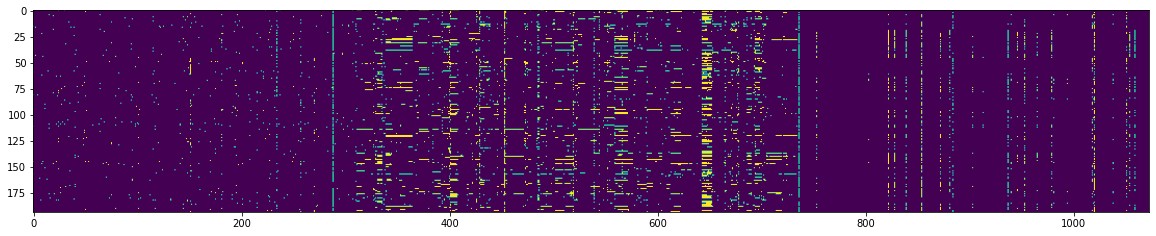

In [61]:
plt.figure(figsize=(20,40))
plt.imshow(df_train_X_CellLines)

In [62]:
X_columns_CosmicID_DrugID = ["COSMIC_ID","DRUG_ID"]+ X_columns
df_train_X = df_train_drug_new[X_columns_CosmicID_DrugID]
df_group_train_X_drugs = df_train_X.drop_duplicates(subset ="DRUG_ID")
df_group_train_X_drugs

,COSMIC_ID,DRUG_ID,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,687596,133,1.024,543.50,9.0,0.0,1.3,0.0,206.0,977.0,...,0,0,0,0,0,0,0,0,0,0
1,687596,135,1.024,263.20,3.0,0.0,-1.5,0.0,108.0,426.0,...,0,0,0,0,0,0,0,0,0,0
2,687596,136,16.000,334.33,5.0,0.0,-0.4,0.0,147.0,757.0,...,0,0,0,0,0,0,0,0,0,0
3,687596,140,0.064,778.90,12.0,0.0,3.6,0.0,134.0,1690.0,...,0,0,0,0,0,0,0,0,0,0
4,687596,151,10.240,567.70,16.0,0.0,7.6,0.0,85.1,842.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,687997,306,10.240,524.70,11.0,0.0,4.8,0.0,117.0,787.0,...,0,0,0,0,0,0,0,0,0,0
1108,687997,1025,10.000,371.20,10.0,0.0,3.9,0.0,51.1,621.0,...,0,0,0,0,0,0,0,0,0,0
1380,688013,94,10.000,364.40,8.0,0.0,1.9,0.0,57.2,710.0,...,0,0,0,0,0,0,0,0,0,0
1423,688013,1061,5.000,453.50,12.0,0.0,2.1,0.0,78.3,1080.0,...,0,0,0,0,0,0,0,0,0,0


(194, 1073)

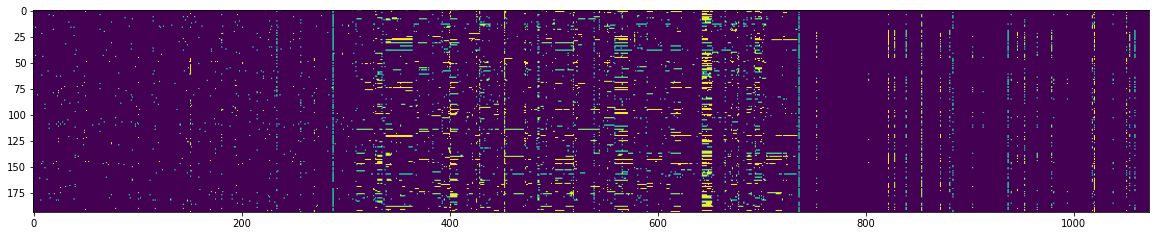

In [63]:
scaler_cells = MinMaxScaler().fit(df_train_X_CellLines)
X_cells_features = scaler_cells.transform(df_train_X_CellLines)
plt.figure(figsize=(20,40))
plt.imshow(X_cells_features)
X_cells_features.shape

In [64]:
Matrix_cells_corr = np.corrcoef(X_cells_features)
print(np.corrcoef(X_cells_features[0,:],X_cells_features[1,:]))

[[1.         0.37397485]
 [0.37397485 1.        ]]


In [65]:
np.savetxt(path_to_save+"Matrix_cells.csv", Matrix_cells_corr, delimiter=",")
Matrix_cells_corr

array([[1.        , 0.37397485, 0.1204981 , ..., 0.28290845, 0.26740543,
        0.01569487],
       [0.37397485, 1.        , 0.11356118, ..., 0.24161317, 0.37865103,
        0.3104968 ],
       [0.1204981 , 0.11356118, 1.        , ..., 0.14244564, 0.14988251,
        0.22996927],
       ...,
       [0.28290845, 0.24161317, 0.14244564, ..., 1.        , 0.09453401,
        0.13423473],
       [0.26740543, 0.37865103, 0.14988251, ..., 0.09453401, 1.        ,
        0.11962363],
       [0.01569487, 0.3104968 , 0.22996927, ..., 0.13423473, 0.11962363,
        1.        ]])

In [66]:
#df_group_train_X_drugs.sort_values("DRUG_ID")
#plt.plot(df_group_train_X_drugs["DRUG_ID"])
#plt.plot(df_group_train_X_drugs.sort_values("DRUG_ID"))
df_group_train_X_drugs_sorted = df_group_train_X_drugs.sort_values("DRUG_ID").reset_index()

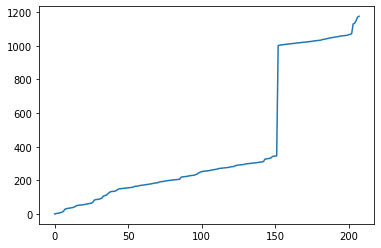

In [67]:
plt.plot(df_group_train_X_drugs_sorted["DRUG_ID"])

In [68]:
df_train_X_Drugs =  df_group_train_X_drugs_sorted[X_columns_drugs]
df_train_X_Drugs

,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,h_bond_donor_count,h_bond_acceptor_count,...,DNA replication,Hormone-related,Genome integrity,WNT signaling,JNK and p38 signaling,Chromatin other,Metabolism,Apoptosis regulation,Chromatin histone methylation,p53 pathway
0,2.0,393.4,8.0,1.0,3.3,0.0,74.7,525.0,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,0.1,914.2,9.0,0.0,6.0,0.0,195.0,1760.0,3.0,13.0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,398.5,8.0,0.0,2.6,0.0,77.2,636.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,641.6,13.0,0.0,5.0,0.0,111.0,1180.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,475.6,7.0,0.0,4.8,0.0,114.0,644.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,10.0,390.4,7.0,0.0,3.2,0.0,60.9,510.0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
204,10.0,328.4,10.0,0.0,4.6,0.0,52.7,387.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,1
205,5.0,573.7,15.0,0.0,7.8,0.0,132.0,963.0,4.0,6.0,...,0,0,0,0,0,0,0,1,0,0
206,10.0,352.4,8.0,0.0,3.7,0.0,87.6,479.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0


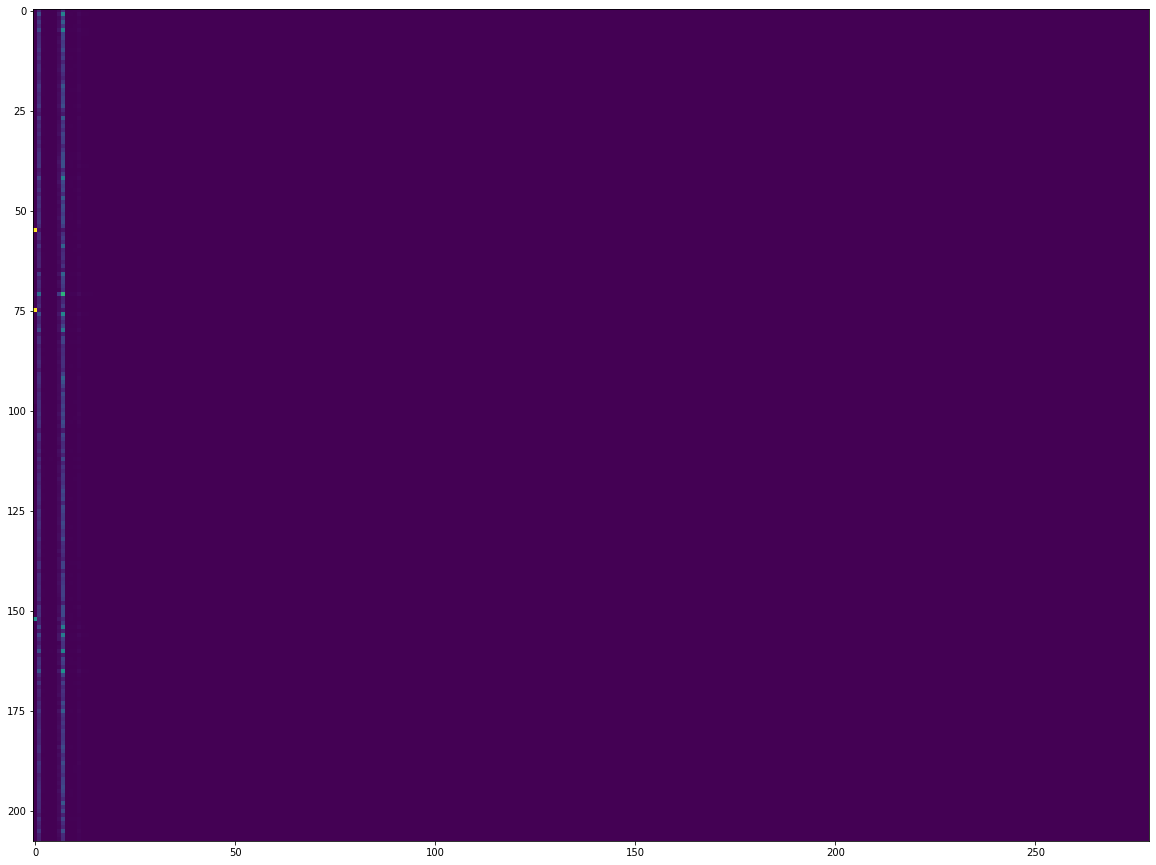

In [69]:
plt.figure(figsize=(20,40))
plt.imshow(df_train_X_Drugs)

(208, 279)

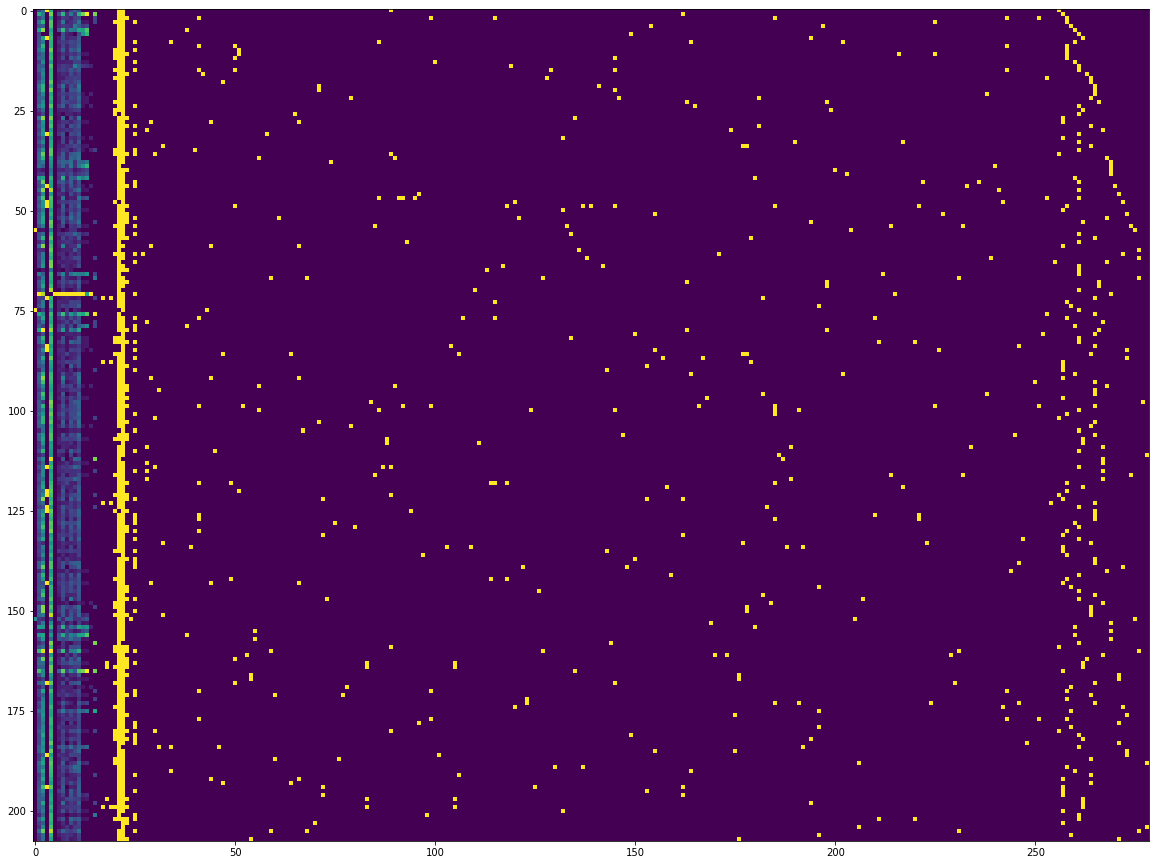

In [70]:
scaler_drugs = MinMaxScaler().fit(df_train_X_Drugs)
X_drug_features = scaler_drugs.transform(df_train_X_Drugs)
#Xtest_drug = scaler.transform(df_test_drug_new[X_columns])
plt.figure(figsize=(20,40))
plt.imshow(X_drug_features)
X_drug_features.shape

In [71]:
Matrix_drug_corr = np.corrcoef(X_drug_features)
print(np.corrcoef(X_drug_features[0,:],X_drug_features[1,:]))

[[1.         0.42778051]
 [0.42778051 1.        ]]


In [72]:
np.savetxt(path_to_save+"Matrix_drugs.csv", Matrix_drug_corr, delimiter=",")
Matrix_drug_corr

array([[1.        , 0.42778051, 0.31725519, ..., 0.41879327, 0.50409128,
        0.40763753],
       [0.42778051, 1.        , 0.3086322 , ..., 0.41507195, 0.46822864,
        0.36990667],
       [0.31725519, 0.3086322 , 1.        , ..., 0.28548114, 0.35360304,
        0.40663241],
       ...,
       [0.41879327, 0.41507195, 0.28548114, ..., 1.        , 0.46355803,
        0.37038302],
       [0.50409128, 0.46822864, 0.35360304, ..., 0.46355803, 1.        ,
        0.45638295],
       [0.40763753, 0.36990667, 0.40663241, ..., 0.37038302, 0.45638295,
        1.        ]])

In [73]:
df_train_X_Drugs

,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,h_bond_donor_count,h_bond_acceptor_count,...,DNA replication,Hormone-related,Genome integrity,WNT signaling,JNK and p38 signaling,Chromatin other,Metabolism,Apoptosis regulation,Chromatin histone methylation,p53 pathway
0,2.0,393.4,8.0,1.0,3.3,0.0,74.7,525.0,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,0.1,914.2,9.0,0.0,6.0,0.0,195.0,1760.0,3.0,13.0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,398.5,8.0,0.0,2.6,0.0,77.2,636.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,641.6,13.0,0.0,5.0,0.0,111.0,1180.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,475.6,7.0,0.0,4.8,0.0,114.0,644.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,10.0,390.4,7.0,0.0,3.2,0.0,60.9,510.0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
204,10.0,328.4,10.0,0.0,4.6,0.0,52.7,387.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,1
205,5.0,573.7,15.0,0.0,7.8,0.0,132.0,963.0,4.0,6.0,...,0,0,0,0,0,0,0,1,0,0
206,10.0,352.4,8.0,0.0,3.7,0.0,87.6,479.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
#Matrix_drug_corr.shape
#Matrix_cells_corr.shape

In [75]:
val_id

array([   0,   19,   21, ..., 9093, 9096, 9105])

In [76]:
len(IC50)

9108

In [77]:
val_id

array([   0,   19,   21, ..., 9093, 9096, 9105])

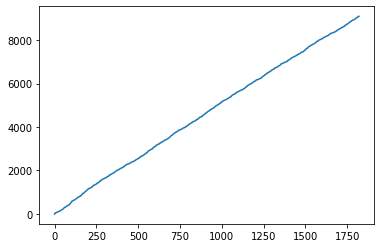

In [78]:
plt.plot(val_id)